In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import random
from sktime.forecasting.naive import NaiveForecaster
from sktime.utils.plotting import plot_series
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

import numpy as np

random.seed(30)

df = pd.read_csv("data/us_change.csv", index_col=0)
df

,Quarter,Consumption,Income,Production,Savings,Unemployment
1,1970 Q1,0.618566,1.044801,-2.452486,5.299014,0.9
2,1970 Q2,0.451984,1.225647,-0.551459,7.789894,0.5
3,1970 Q3,0.872872,1.585154,-0.358652,7.403984,0.5
4,1970 Q4,-0.271848,-0.239545,-2.185691,1.169898,0.7
5,1971 Q1,1.901345,1.975925,1.909764,3.535667,-0.1
...,...,...,...,...,...,...
194,2018 Q2,0.983112,0.661825,1.117424,-2.723974,0.0
195,2018 Q3,0.853181,0.806271,1.256722,-0.085686,-0.3
196,2018 Q4,0.356512,0.695142,0.948148,5.031337,0.2
197,2019 Q1,0.282885,1.100753,-0.488206,9.760287,-0.1


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 198 entries, 1 to 198
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Quarter       198 non-null    object 
 1   Consumption   198 non-null    float64
 2   Income        198 non-null    float64
 3   Production    198 non-null    float64
 4   Savings       198 non-null    float64
 5   Unemployment  198 non-null    float64
dtypes: float64(5), object(1)
memory usage: 10.8+ KB


In [3]:
df.describe()

,Consumption,Income,Production,Savings,Unemployment
count,198.000000,198.000000,198.000000,198.000000,198.000000
mean,0.742482,0.728169,0.507083,1.392258,0.001010
std,0.637863,0.900393,1.521350,11.966324,0.367318
min,-2.277836,-4.084420,-6.836039,-56.471910,-0.900000
25%,0.417479,0.314376,-0.010780,-4.049088,-0.200000
50%,0.776656,0.760346,0.666085,1.349359,-0.100000
75%,1.097577,1.160228,1.295245,6.341144,0.100000
max,2.319558,4.521869,4.154295,41.607730,1.400000


Utilizaremos modelos baselines como benchmarks para avaliar o desempenho de futuros modelos mais complexos. Esses modelos simples não terão grandes mudanças nos dados, como transformações ou técnicas adicionais. Isso serve para entendermos os resultados da maneira mais simples possível.

In [4]:
def convert_to_period(quarter):
    """
    Function to convert a string to a pandas period object. 
    Checks if the input is a string in the form '2019 Q1' or already a Period.
    """
    if isinstance(quarter, pd.Period):
        return quarter
    year, quarter_str = quarter.split()
    year = int(year)
    quarter = int(quarter_str[-1])
    return pd.Period(year=year, quarter=quarter, freq='Q')

df['Quarter'] = df['Quarter'].apply(convert_to_period)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 198 entries, 1 to 198
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype        
---  ------        --------------  -----        
 0   Quarter       198 non-null    period[Q-DEC]
 1   Consumption   198 non-null    float64      
 2   Income        198 non-null    float64      
 3   Production    198 non-null    float64      
 4   Savings       198 non-null    float64      
 5   Unemployment  198 non-null    float64      
dtypes: float64(5), period[Q-DEC](1)
memory usage: 10.8 KB


In [6]:
flt = (df["Quarter"] >= "1970Q1") & (df["Quarter"] <= "2019Q2")
Consumption = df[["Quarter", "Consumption"]][flt]
Consumption.set_index("Quarter", inplace=True)

Consumption.head()

# Apply Z-Score Normalization
scaler = StandardScaler()
Consumption["Consumption"] = scaler.fit_transform(Consumption[["Consumption"]])

# Ensure it is a Series and set a compatible index (PeriodIndex)
Consumption.index = pd.PeriodIndex(Consumption.index, freq="Q")
Consumption = Consumption["Consumption"]  # Convert to pandas Series

In [24]:
def fit_and_plot(dataset, strategy, sp=1):
    """
    Function to fit a forecasting strategy and plot the results,
    including the calculation of MAE, RMSE, and MASE.
    """
    train, test = dataset[:-40], dataset[-40:]

    # Fit the forecaster
    forecaster = NaiveForecaster(strategy=strategy, sp=sp)
    forecaster.fit(train)
    
    # Make predictions
    y_pred = forecaster.predict(list(range(1, 41)))

    # Revert predictions and test set to the original scale
    y_pred_original = pd.Series(
        scaler.inverse_transform(y_pred.values.reshape(-1, 1)).flatten(),
        index=y_pred.index
    )
    test_original = pd.Series(
        scaler.inverse_transform(test.values.reshape(-1, 1)).flatten(),
        index=test.index
    )

    # Revert the dataset to the original scale for plotting
    dataset_original = pd.Series(
        scaler.inverse_transform(dataset.values.reshape(-1, 1)).flatten(),
        index=dataset.index
    )

    # Predict intervals
    pred_intervals_95 = forecaster.predict_interval(coverage=0.95)
    pred_intervals_80 = forecaster.predict_interval(coverage=0.80)
    
    # Calculate error metrics
    mae = mean_absolute_error(test_original, y_pred_original)
    rmse = np.sqrt(mean_squared_error(test_original, y_pred_original))

    print(f"MAE: {mae:.2f}")
    print(f"MSE: {rmse:.2f}")
    
    # Define method names
    method = {
        "last": "Naive Method",
        "mean": "Mean Method",
        "drift": "Drift Method",
        "seasonal_last": "Seasonal Naive Method",
    }
    
    if sp != 1:
        method["last"] = f"Seasonal Naive Method"

    # Plot results with 95% prediction interval
    fig_1, ax_1 = plot_series(
        dataset_original,
        y_pred_original,
        labels=["y_train", "y_pred"], 
        pred_interval=pred_intervals_95,
        title=f"Consumption Prediction - {method[strategy]}",
    )
    ax_1.grid(linestyle="--", zorder=5, linewidth=0.5)
    plt.xlabel("Year")

    # Plot results with 80% prediction interval
    fig_2, ax_2 = plot_series(
        dataset_original,
        y_pred_original,
        labels=["y_train", "y_pred"],
        pred_interval=pred_intervals_80,
        title=f"Consumption Prediction - {method[strategy]}",
    )
    ax_2.grid(linestyle="--", zorder=5, linewidth=0.5)
    plt.xlabel("Year")
    
    plt.show()



### Mean Method

MAE: 0.29
MSE: 0.36


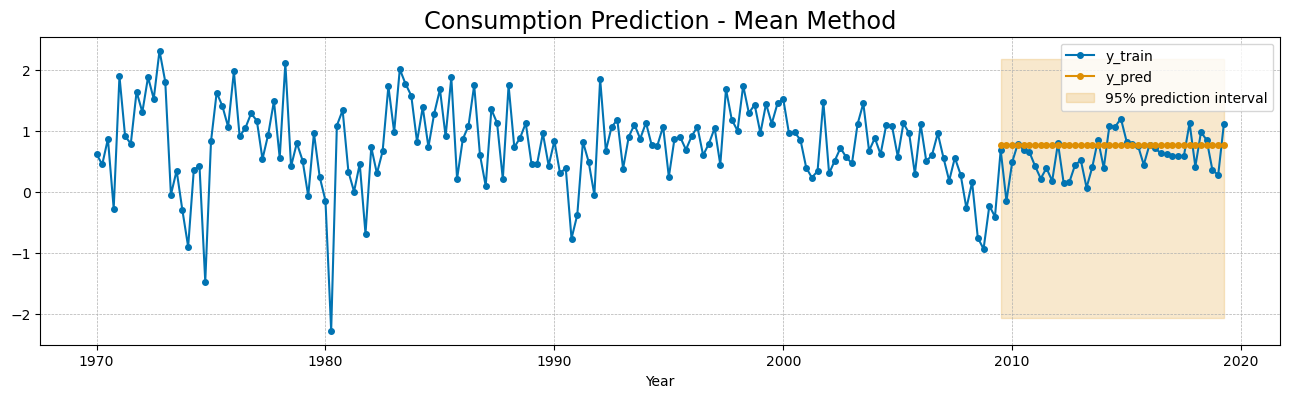

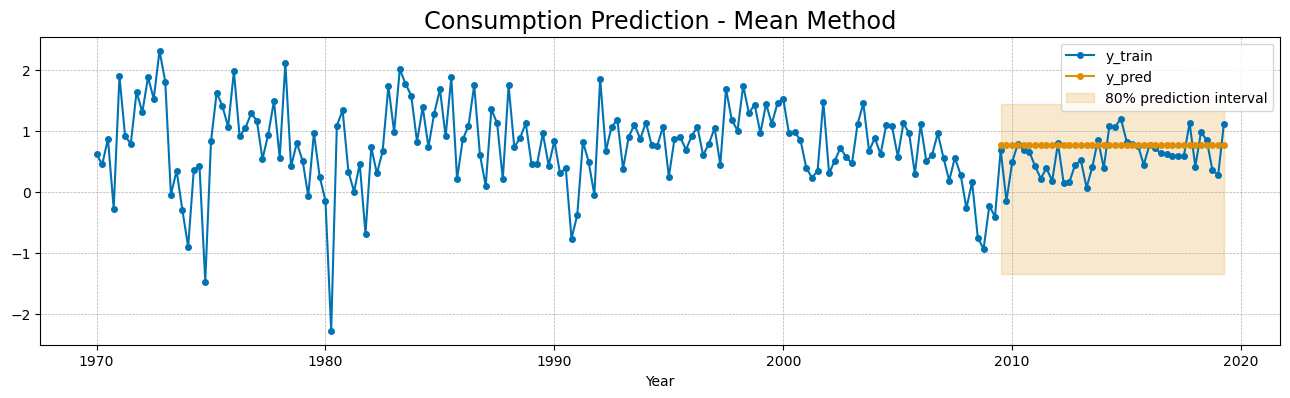

In [25]:
fit_and_plot(Consumption, strategy="mean")

### Naive (or random walk) method

MAE: 1.01
MSE: 1.05


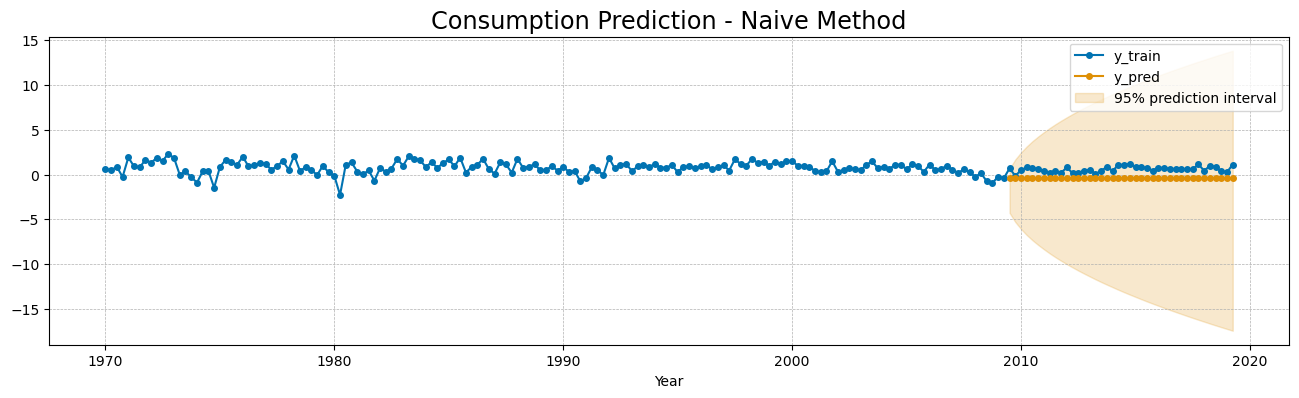

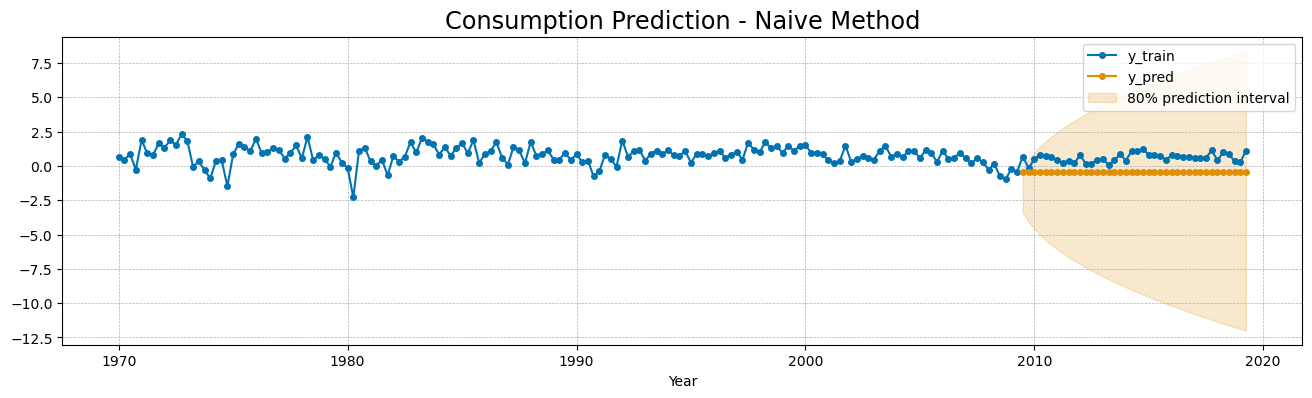

In [26]:
fit_and_plot(Consumption, strategy="last")

### Seasonal Naive method

MAE: 1.18
MSE: 1.25


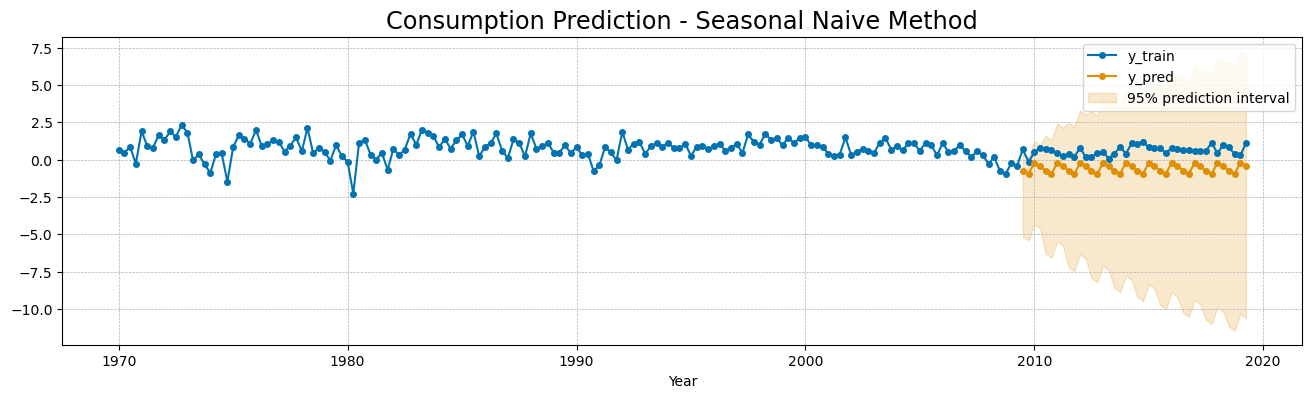

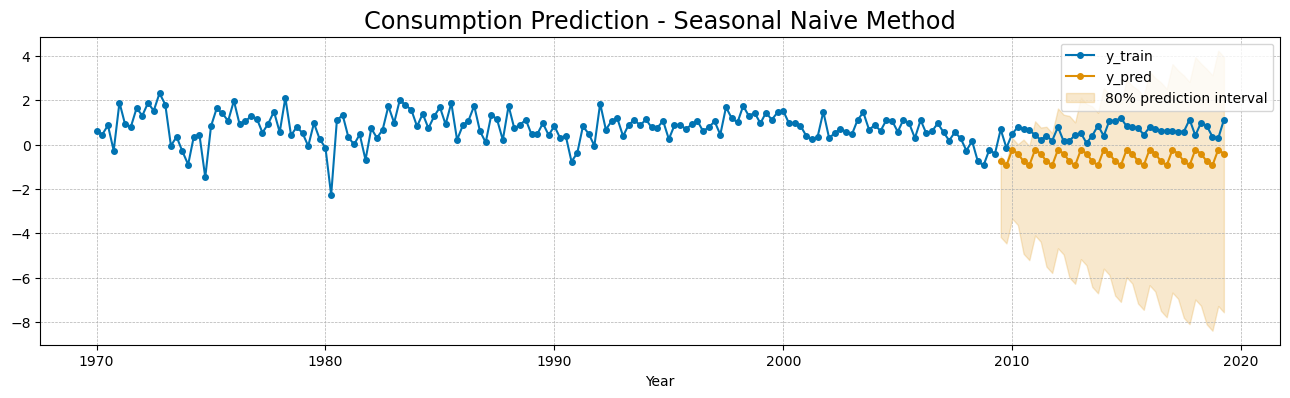

In [27]:
fit_and_plot(Consumption, strategy="last", sp=4)

### Drift method

MAE: 1.14
MSE: 1.19


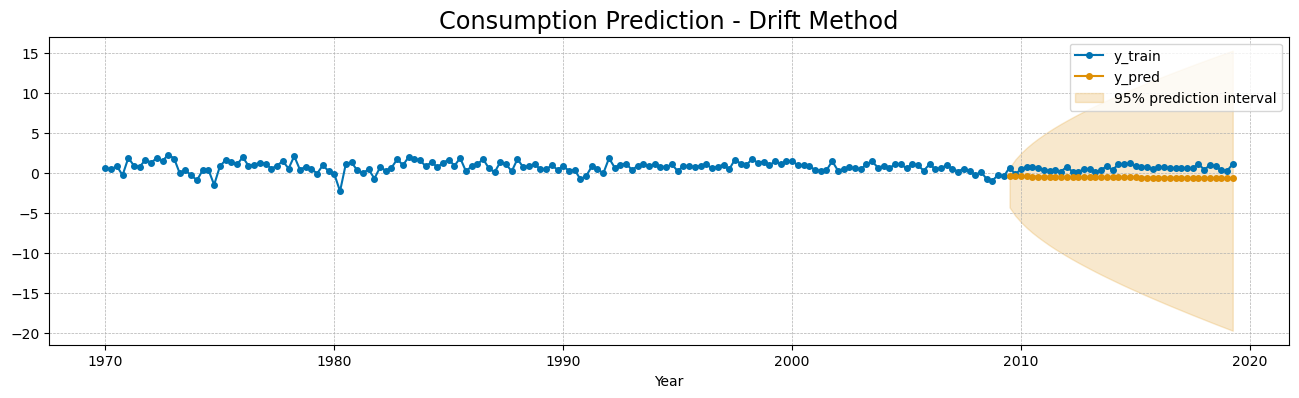

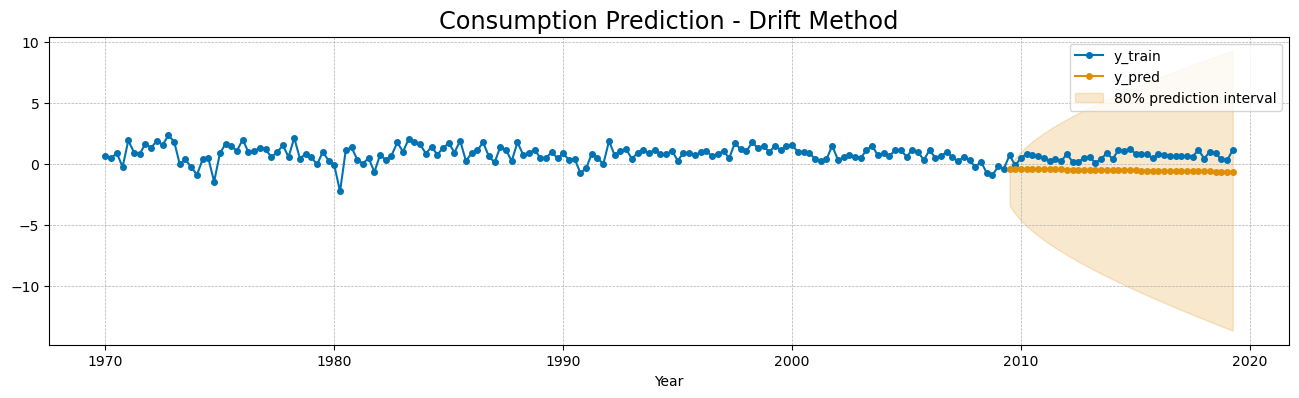

In [28]:
fit_and_plot(Consumption, strategy="drift")
